/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Pleas

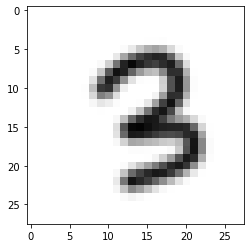

识别结果:
3


In [1]:
import tensorflow as tf 
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image, ImageFilter

import matplotlib.pyplot as plt
#载入数据
mnist = input_data.read_data_sets("/root/code/MNIST_data/",one_hot=True)
#载入图片是 28*28
n_inputs = 28 #输入一共28行
max_time = 28 #一共28行
lstm_size = 100#隐层单元 block
n_classes = 10 #10个分类
batch_size = 50 #每批次50个样本
n_batch = mnist.train.num_examples//batch_size #计算一共有多少批次

#这里的none 表示第一维度可以为任意长度
x = tf.placeholder(tf.float32,[None,784],name='x')
#正确的标签
y = tf.placeholder(tf.float32,[None,10],name='y')
keep_prob = tf.placeholder("float",name='keep_prob')
#初始化权重
weights = tf.Variable(tf.truncated_normal([lstm_size,n_classes],stddev=0.1))
#初始化偏置
biases =tf.Variable(tf.constant(0.1,shape=[n_classes]))

#定义run网络
def RUN(X,weights,biases,re_name):
    # inputs = [batch_size,max_time,n_inputs]
    inputs = tf.reshape(X,[-1,max_time,n_inputs])
    #定义LSTM基本CELL
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
    #final_state[0]是cell state
    #final_state[1]是hidden state
    outputs,final_state = tf.nn.dynamic_rnn(lstm_cell,inputs,dtype=tf.float32)
    results = tf.nn.softmax(tf.matmul(final_state[1],weights)+biases,name=re_name)
    return results

#计算RUN的返回结果
result = "result"
prediction = RUN(x,weights,biases,result)

# cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
#结果存放在一个布尔型列表中
correct_prediction= tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
#求准确率

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')


#写预测接口 一串函数写进去？
# predition_L = tf.argmax(tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2),1)
# prediction=tf.argmax(y_conv,1)


#sess 之前定义的 graph ckpt类模型文件只保存 权重偏置等模型数据 不保存 graph图 所以 需要再构建一次 图

saver = tf.train.Saver()
sess = tf.Session()

sess.run(tf.global_variables_initializer())
saver.restore(sess, '/tmp/tf_rnn_1/model.ckpt') #使用模型，参数和之前的代码保持一致

prediction=tf.argmax(prediction,1)
im = Image.open('/root/code/pic_png/3.png') #读取的图片所在路径，注意是28*28像素
plt.imshow(im)  #显示需要识别的图片
plt.show()
im = im.convert('L')
tv = list(im.getdata()) 
tva = [(255-x)*1.0/255.0 for x in tv] 
predint=prediction.eval(feed_dict={x: [tva],keep_prob: 1.0}, session=sess)
#TypeError: eval() got an unexpected keyword argument 'name' 这是不是代表 sess.run的函数方式行不通了
print('识别结果:')
print(predint[0])
#用了函数处理 图像数据 所以用x:【result】

In [2]:
def predict10(sess, adds):
    import json
    num_imgs = len(adds)
    result = []
    for i in range(num_imgs):
        data = json.loads(adds[i])
        predints=sess.run('result:0',feed_dict={"x:0":data,"keep_prob:0": 1.0})
        result.append(str(predints[0]))
    
    return result
# predict9(sess,tva_c) 成功预测 并部署通过 数据处理可得到 预测结果

In [3]:
from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers.tensorflow import deploy_tensorflow_model
clipper_conn = ClipperConnection(DockerContainerManager())

In [4]:
clipper_conn.start_clipper()

20-07-16:20:46:49 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
20-07-16:20:46:54 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /tmp/tmp6o5nmyqz.yml
20-07-16:20:46:55 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [5]:
clipper_conn.connect()

20-07-16:20:46:56 INFO     [clipper_admin.py:172] [default-cluster] Successfully connected to Clipper cluster at localhost:1337


In [6]:
clipper_conn.register_application(
    name="mnist_rnn-app", input_type="strings", default_output="-1.0", slo_micros=100000)

20-07-16:20:46:57 INFO     [clipper_admin.py:236] [default-cluster] Application mnist_rnn-app was successfully registered


In [7]:
deploy_tensorflow_model(
    clipper_conn,
    name="mnist-rnn-mod",
    version=1, # version 2 of the same model, `predict` endpoint will be updated 
    # automatically to the newest model version
    input_type="strings",
     func=predict10,
    tf_sess_or_saved_model_path=sess,
   )

20-07-16:20:47:00 INFO     [deployer_utils.py:41] Saving function to /tmp/tmpsolcf2_lclipper
20-07-16:20:47:00 INFO     [deployer_utils.py:51] Serialized and supplied predict function
20-07-16:20:47:00 INFO     [tensorflow.py:196] TensorFlow model saved at: /tmp/tmpsolcf2_lclipper/tfmodel/model.ckpt 
20-07-16:20:47:00 INFO     [tensorflow.py:277] Using Python 3.6 base image
20-07-16:20:47:00 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /tmp/tmpsolcf2_lclipper
20-07-16:20:47:00 INFO     [clipper_admin.py:539] [default-cluster] Step 1/2 : FROM clipper/tf36-container:0.4.1
20-07-16:20:47:00 INFO     [clipper_admin.py:539] [default-cluster]  ---> 3db42af800ff
20-07-16:20:47:00 INFO     [clipper_admin.py:539] [default-cluster] Step 2/2 : COPY /tmp/tmpsolcf2_lclipper /model/
20-07-16:20:47:00 INFO     [clipper_admin.py:539] [default-cluster]  ---> 14c7044119c7
20-07-16:20:47:00 INFO     [clipper_admin.py:539] [default-cluster] Successfull

In [8]:
sess

In [8]:
# Link the model and the app
clipper_conn.link_model_to_app(
    app_name="mnist_rnn-app",
    model_name="mnist-rnn-mod")

20-07-16:20:47:34 INFO     [clipper_admin.py:303] [default-cluster] Model mnist-rnn-mod is now linked to application mnist_rnn-app


In [9]:
# Get query address
query_address = clipper_conn.get_query_addr()
print(query_address)

localhost:1337


In [10]:
import matplotlib.pyplot as plt
import base64
import json
import requests
from datetime import datetime



def query_json(addr, filename,mnist,sess):
    url = "http://%s/mnist_rnn-app/predict" % addr

    im = Image.open(filename)
    plt.imshow(im)  #显示需要识别的图片
    plt.show()
    im = im.convert('L')
    tv = list(im.getdata())
    tva = [[(255-x)*1.0/255.0 for x in tv]]
    tva = json.dumps(tva)
    tva_j = json.dumps({"input": tva})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    r = requests.post(url, headers=headers, data=tva_j)
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    re = r.text
    global false, null, true

    false = null = true = ''
    ls = eval(re)
    numbers = ls['output']
    numbers_str = numbers[1:-1]
    numbers_str=numbers_str.replace("\n", "")
    list1 = numbers_str.split(' ')
    print("this number is "+ str(list1.index(max(list1)))+" , "+"The latency is   "+str(latency))
    print('test accuracy %g' % accuracy.eval(feed_dict={
        "x:0": mnist.test.images, "y:0": mnist.test.labels, keep_prob: 1.0},session=sess))
    return (list1.index(max(list1)))

Extracting /root/code/MNIST_data/train-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /root/code/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /root/code/MNIST_data/t10k-labels-idx1-ubyte.gz


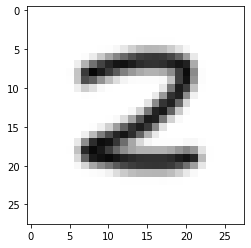

this number is 2 , The latency is   20.91
test accuracy 0.898


2

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/root/code/MNIST_data/', one_hot=True) 
query_json(query_address, "/root/code/pic_png/2.png",mnist,sess)

In [15]:
clipper_conn.stop_all()

20-07-16:20:50:08 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers
